In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import itertools
from sklearn import svm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon

from sqlalchemy import create_engine

print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.19.0.


In [66]:
engine = create_engine('postgresql://localhost:5432/ifprates')
raw_df = pd.read_sql_query('SELECT * FROM reports.v_enrollment_summary_dataset', engine)

In [67]:
sorted(raw_df.columns)

['businessyear',
 'category',
 'count_bronze',
 'count_cat',
 'count_gold',
 'count_silver',
 'county_name',
 'fips_code',
 'fips_code_5_digit',
 'index',
 'insured_below138fpl',
 'insured_subsidy_elig',
 'issuer_count',
 'max_price_bronze',
 'max_price_cat',
 'max_price_gold',
 'max_price_silver',
 'mean_price_bronze',
 'mean_price_cat',
 'mean_price_gold',
 'mean_price_silver',
 'min_price_bronze',
 'min_price_cat',
 'min_price_gold',
 'min_price_silver',
 'pct_below138fpl_uninsured',
 'pct_change_count_bronze',
 'pct_change_count_cat',
 'pct_change_count_gold',
 'pct_change_count_silver',
 'pct_change_issuer_count',
 'pct_change_mean_price_bronze',
 'pct_change_mean_price_cat',
 'pct_change_mean_price_gold',
 'pct_change_mean_price_silver',
 'pct_change_min_price_bronze',
 'pct_change_min_price_cat',
 'pct_change_min_price_gold',
 'pct_change_min_price_silver',
 'pct_change_second_lowest_silver',
 'pct_subsidy_elig_uninsured',
 'poverty_to_subsidy_ratio',
 'prior_count_bronze',
 'pr

In [90]:
# Remove categorical coulumns that should not be considered in the model, or remove other columns to test
# the sensitivity of the clasifficaiton to certain features. 
drop_col = [
#     'businessyear',
#     'statecode',
#     'category',
#     'county_name',
#     'fips_code_5_digit',
    'count_bronze',
    'count_cat',
    'count_gold',
    'count_silver',

    'index',
#     'insured_below138fpl',
#     'insured_subsidy_elig',
    'issuer_count',
    'max_price_bronze',
    'max_price_cat',
    'max_price_gold',
    'max_price_silver',
#     'mean_price_bronze',
#     'mean_price_cat',
#     'mean_price_gold',
#     'mean_price_silver',
    'min_price_bronze',
    'min_price_cat',
    'min_price_gold',
    'min_price_silver',
#     'pct_below138fpl_uninsured',
    'pct_change_count_bronze',
    'pct_change_count_cat',
    'pct_change_count_gold',
    'pct_change_count_silver',
    'pct_change_issuer_count',
#     'pct_change_mean_price_bronze',
#     'pct_change_mean_price_cat',
#     'pct_change_mean_price_gold',
#     'pct_change_mean_price_silver',
    'pct_change_min_price_bronze',
    'pct_change_min_price_cat',
    'pct_change_min_price_gold',
    'pct_change_min_price_silver',
    'pct_change_second_lowest_silver',
#     'pct_subsidy_elig_uninsured',
#     'poverty_to_subsidy_ratio',
    'prior_count_bronze',
    'prior_count_cat',
    'prior_count_gold',
    'prior_count_silver',
    'prior_issuer_count',
    'prior_mean_price_bronze',
    'prior_mean_price_cat',
    'prior_mean_price_gold',
    'prior_mean_price_silver',
    'prior_min_price_bronze',
    'prior_min_price_cat',
    'prior_min_price_gold',
    'prior_min_price_silver',
    'prior_second_lowest_silver',
    'rating_area_name',
    'second_lowest_silver',
#     'total_below138fpl',
#     'total_subsidy_elig',
#     'uninsured_below138fpl',
#     'uninsured_subsidy_elig',        
    'tier_catastrophic',   
    'tier_bronze',
    'tier_silver',         
    'tier_gold',           
    'tier_platinum',       
    'fips_code'         
]

df = raw_df.drop(drop_col, axis=1)
len(df)

13076

In [92]:
# will have fips and county
df_clean_fips_county = df.dropna(axis=0, how='any').reset_index(drop=True) 
rows = len(df_clean)
print('Query returns %r rows' % rows)
print('%r rows were droped due to incomplete cases' % ((len(df)) - rows))

Query returns 11500 rows
1576 rows were droped due to incomplete cases


In [93]:
df_clean = df_clean_fips_county.drop(['county_name','fips_code_5_digit'], axis=1)
df_clean = pd.get_dummies(df_clean)
    
shape = df_clean.shape
df_clean.dtypes

businessyear                      int64
category                          int64
mean_price_cat                  float64
pct_change_mean_price_cat       float64
mean_price_bronze               float64
pct_change_mean_price_bronze    float64
mean_price_silver               float64
pct_change_mean_price_silver    float64
mean_price_gold                 float64
pct_change_mean_price_gold      float64
total_subsidy_elig              float64
uninsured_subsidy_elig          float64
insured_subsidy_elig            float64
total_below138fpl               float64
uninsured_below138fpl           float64
insured_below138fpl             float64
poverty_to_subsidy_ratio        float64
pct_subsidy_elig_uninsured      float64
pct_below138fpl_uninsured       float64
statecode_AL                      uint8
statecode_AR                      uint8
statecode_AZ                      uint8
statecode_DE                      uint8
statecode_FL                      uint8
statecode_GA                      uint8


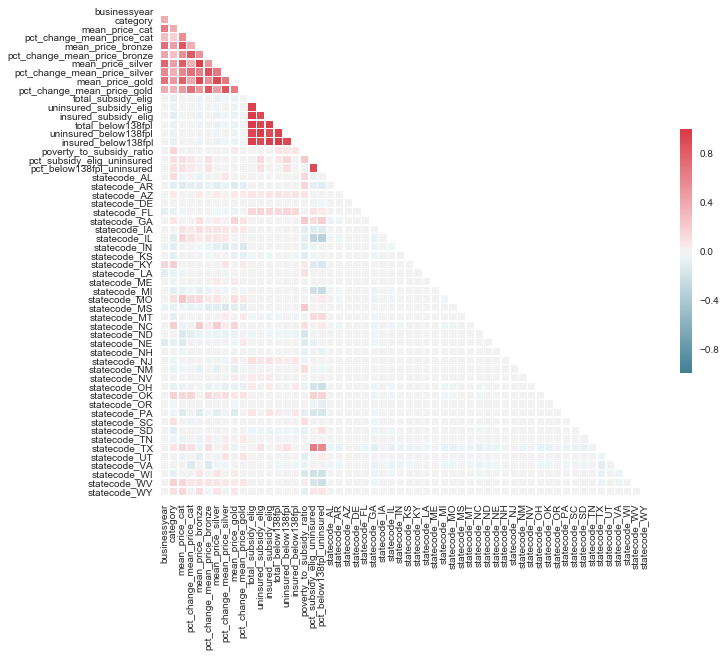

In [94]:
sns.set(style="white")

# Compute the correlation matrix
corr = df_clean.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [95]:
data = df_clean.drop(['category'], axis=1)
labels = df_clean.category

X = pd.DataFrame(data)
y = pd.Series(labels)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, shuffle=True)
print(len(X_train))
print(len(X_test))

5852
2508


In [103]:
X_scaler = StandardScaler().fit(X_train)
y_scaler = LabelEncoder().fit(y_train)

In [104]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print('X_train_scaled has %r observations.' % len(X_train_scaled))
print('y_train_scaled has %r observations.' % len(y_train_scaled))
print('X_test_scaled has %r observations.' % len(X_test_scaled))
print('y_test_scaled has %r observations.' % len(y_test_scaled))

X_train_scaled has 5852 observations.
y_train_scaled has 5852 observations.
X_test_scaled has 2508 observations.
y_test_scaled has 2508 observations.


In [105]:
# parameters = [{'kernel': ['rbf'],
#                'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
#                 'C': [1, 10, 100, 1000]},
#               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# print("# Tuning hyper-parameters")
# print()

# clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters, cv=5)
# clf.fit(X_train, y_train)

# print("Best parameters set found on development set:")
# print()
# print(clf.best_params_)
# print()
# print("Grid scores on training set:")
# print()
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# print()

In [106]:
# Create SVM classification object 
model = svm.SVC(kernel='poly', decision_function_shape='ovo', C=1000,  gamma=0.01) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(X_train_scaled, y_train_scaled)
score = model.score(X_test_scaled, y_test_scaled)
#Predict Output
predicted = model.predict(X_test_scaled)
score

0.96690590111642738

In [107]:
# Run model on the entire data set.
# df_full = df.drop(drop_col, axis=1)
# X_test_full = df_clean.drop(['category'], axis=1)

In [109]:
X_scaler_full = StandardScaler().fit(X)
X_test_scaled_full = X_scaler_full.transform(X)

y_pred = model.predict(X_test_scaled_full)

In [110]:
predictions_full_df = pd.DataFrame(y_pred, columns=['issuer_count_output'])

df_results = df_clean_fips_county.merge(predictions_full_df, right_index=True, left_index=True)
df_results = df_results[['businessyear', 'issuer_count_output', 'fips_code_5_digit', 'category']]

In [111]:
y_true = df_clean_fips_county['category']
confusion_matrix(y_true, y_pred)

array([[6428,   48],
       [ 178, 1706]])

Confusion matrix, without normalization
[[6428   48]
 [ 178 1706]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.09  0.91]]


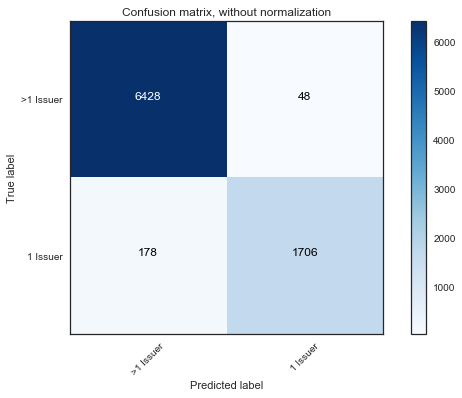

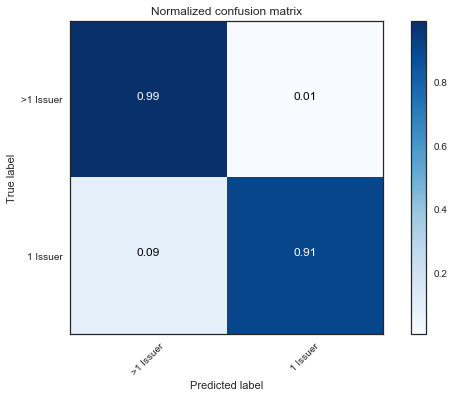

In [112]:
class_names = ['>1 Issuer', '1 Issuer']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [113]:
f1_score(y_true, y_pred, average='macro')  
f1_score(y_true, y_pred, average='micro')  
f1_score(y_true, y_pred, average='weighted')  
f1_score(y_true, y_pred, average=None)


array([ 0.98,  0.94])

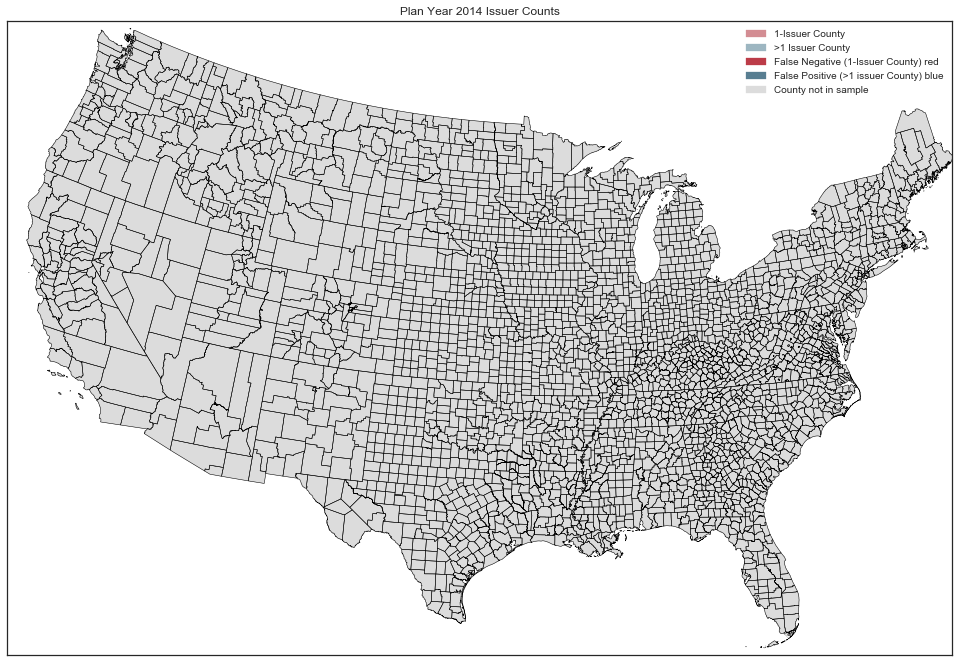

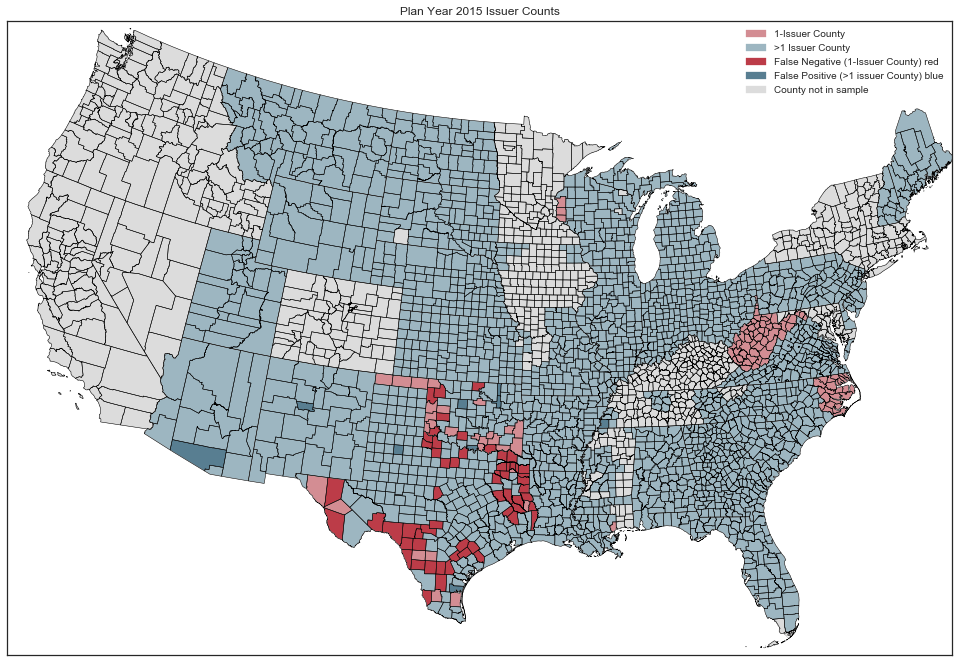

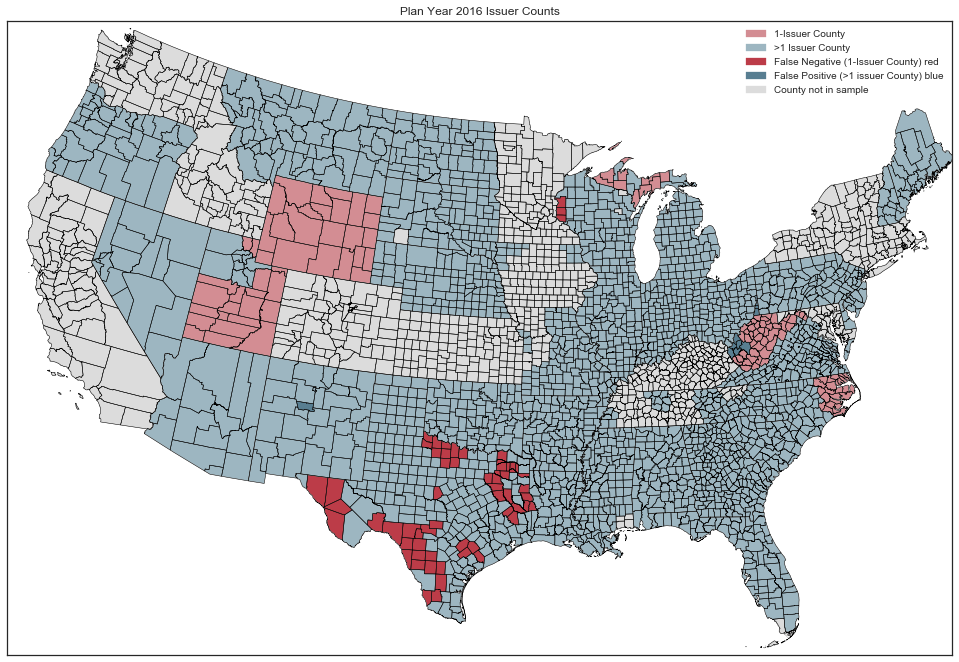

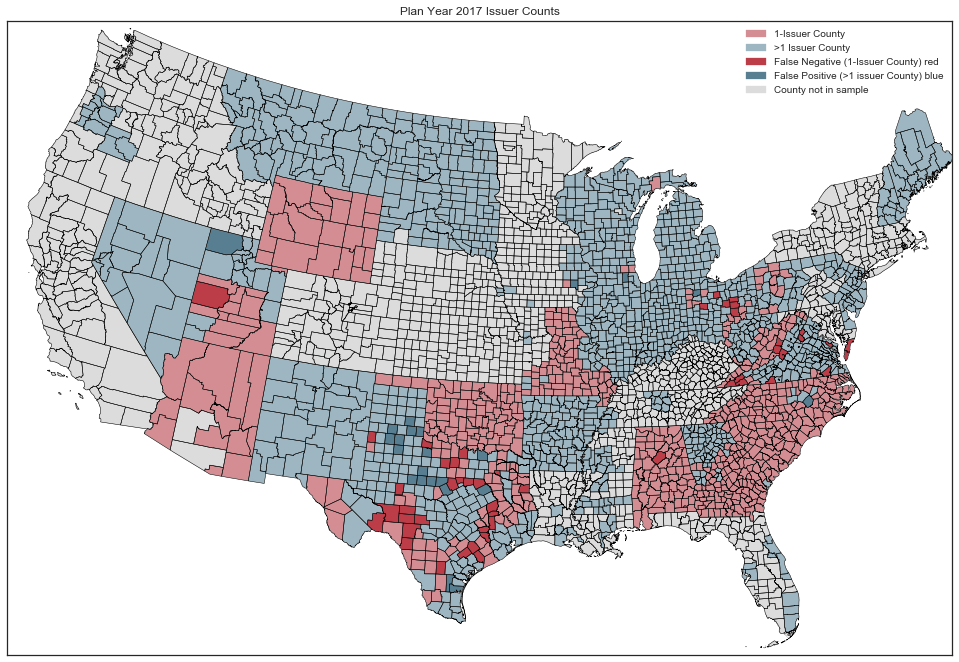

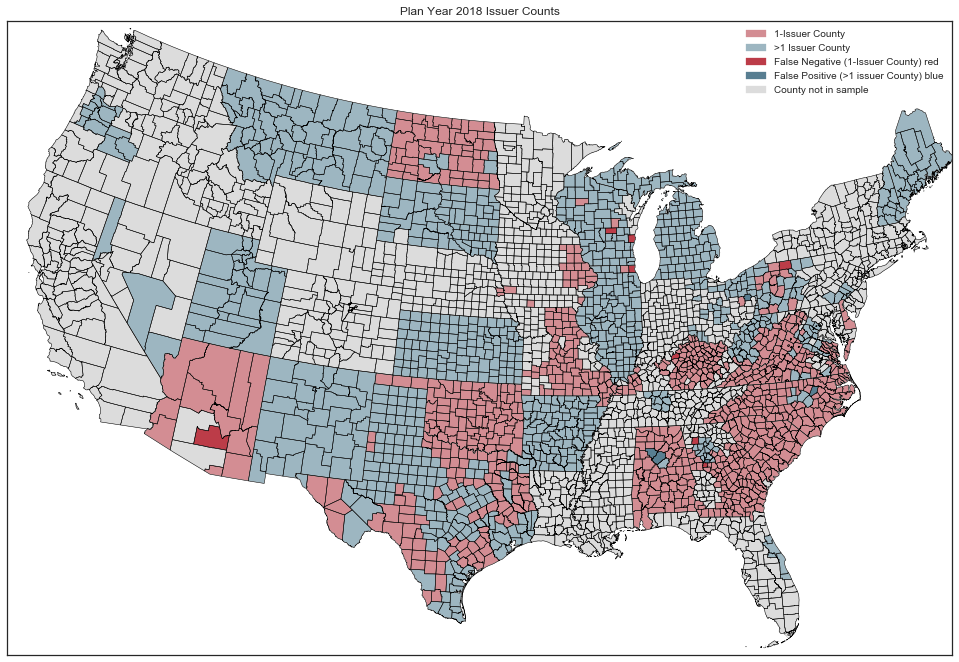

In [114]:
def plot_count_issuer_counts(year, df):
    
    sns.set(style="white")
    
    f, ax = plt.subplots()

    lllon = -119
    urlon = -64
    lllat = 22.0
    urlat = 50.5
    # Calculate a center for the projection.
    centerlon = float(lllon + urlon) / 2.0
    centerlat = float(lllat + urlat) / 2.0

    m = Basemap(resolution='i',  # crude, low, intermediate, high, full
                llcrnrlon = lllon, urcrnrlon = urlon,
                lon_0 = centerlon,
                llcrnrlat = lllat, urcrnrlat = urlat,
                lat_0 = centerlat,
                projection='tmerc')

    # Read state boundaries.
    shp_info = m.readshapefile("shapefiles/census_state_shapes_2016/cb_2016_us_state_500k", 'states',
                               drawbounds=True, color='lightgrey')

    # Read county boundaries.
    shp_info = m.readshapefile('shapefiles/census_county_shapes_2016/cb_2016_us_county_500k',
                               'counties',
                               drawbounds=True)
    # Declare colors.
    one_issuer_color = '#D38D93'
    morethanone_issuer_color = '#9DB6C1'
    false_negative_color = '#BC3C48'
    false_positive_color = '#587E91'
    test_incorrect_class_one_issuer_color = 'magenta'
    test_incorrect_class_morethanone_issuer_color = 'green'
    no_data_color = 'gainsboro'
    
    dfyear = df[df['businessyear'] == year]

    for i, county in enumerate(m.counties_info):
        idx = i
        geoid = county['GEOID']
        try:
            actual = dfyear.loc[dfyear['fips_code_5_digit'] == geoid, 'category'].iloc[0]
            predicted = dfyear.loc[dfyear['fips_code_5_digit'] == geoid, 'issuer_count_output'].iloc[0]
        except:
            actual = 'na'
            predicted = 'na'
        if actual == 'na':
            color = no_data_color
        elif actual == predicted:
            if actual == 1:
                color = one_issuer_color
            elif actual == 0:
                color = morethanone_issuer_color
            else:
                pass
        elif actual != predicted:
            if actual == 1: # False negative red.
                color = false_negative_color
            elif actual == 0: # False positive blue
                color = false_positive_color
        else:
            color = 'black'

        li = [idx, geoid, color]
        poly = Polygon(m.counties[li[0]], facecolor=li[2])  # edgecolor="white"
        ax.add_patch(poly)
    

    ax.set_title('Plan Year %r Issuer Counts' % year)

    one_issuer_patch = mpatches.Patch(color=one_issuer_color, label='1-Issuer County')
    morethanone_issuer_patch = mpatches.Patch(color=morethanone_issuer_color, label='>1 Issuer County')
    false_negative_patch = mpatches.Patch(color=false_negative_color, label='False Negative (1-Issuer County) red')
    false_positive_patch = mpatches.Patch(color=false_positive_color, label='False Positive (>1 issuer County) blue')
    no_data_patch = mpatches.Patch(color=no_data_color, label='County not in sample')


    plt.legend(handles=[one_issuer_patch, morethanone_issuer_patch, false_negative_patch, false_positive_patch, no_data_patch])
    f.set_size_inches(14,9)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()

years = df['businessyear'].unique()
for year in years:
    plot_count_issuer_counts(year=year, df=df_results)
